# **CloudWalk - Empathic Credit System**

CloudWalk has developed a groundbreaking Empathic Credit System (ECS) that uses real-time emotional and contextual data to offer personalized credit to users. This system has been integrated into CloudWalk's mobile app and has collected data from millions of customers.

#### DISCLAIMER

The Empathic Credit Limit System (ECS) described in this case study is entirely fictional. This concept was created solely for the purpose of this exercise and does not represent any real-world technology or system. The idea of using emotional data for credit decisions is purely hypothetical and is meant to stimulate creative thinking and analysis within the context of this technical case.

### Objective

The purpose of this exercise is to analyze the dataset, extract meaningful insights, and provide recommendations to improve the system's effectiveness and fairness.

## **Importing the libraries required**

In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta

## **Loading the dataset**

In [4]:
# Connect to the database
conn = sqlite3.connect('case.db')

# Extract the users table into a dataframe
users_df = pd.read_sql_query("SELECT * FROM users", conn)

# Extract the emotional_data table into a dataframe
emotion_df = pd.read_sql_query("SELECT * FROM emotional_data", conn)

# Extract the loans table into a dataframe
loans_df = pd.read_sql_query("SELECT * FROM loans", conn)

# Close the connection
conn.close()

## **Exploratory Data Analysis**

### Users
Looking at the first rows to understand the dataset structutre.

In [3]:
users_df.head()

,user_id,score,approved_date,denied_date,credit_limit,interest_rate,loan_term
0,1,5.69,2020-05-21,None,32700.0,0.05,12.0
1,2,NaN,None,None,NaN,NaN,NaN
2,3,5.61,2023-12-04,2025-04-26,9500.0,0.09,6.0
3,4,5.64,2020-05-14,None,1800.0,0.11,3.0
4,5,5.64,2021-04-29,None,1700.0,0.11,3.0


Checking the existing columns:

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        734 non-null    int64  
 1   score          667 non-null    float64
 2   approved_date  667 non-null    object 
 3   denied_date    178 non-null    object 
 4   credit_limit   667 non-null    float64
 5   interest_rate  667 non-null    float64
 6   loan_term      667 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 40.3+ KB


Checking the shape:

In [186]:
users_df.shape

(734, 7)

From the above, we know that there are 734 users in the system, and all of them have an ID and a score. The table also contains information about the user loan. 667 users have an approved loan, while 178 were denied a loan.

Let's check how the scores are distributed:

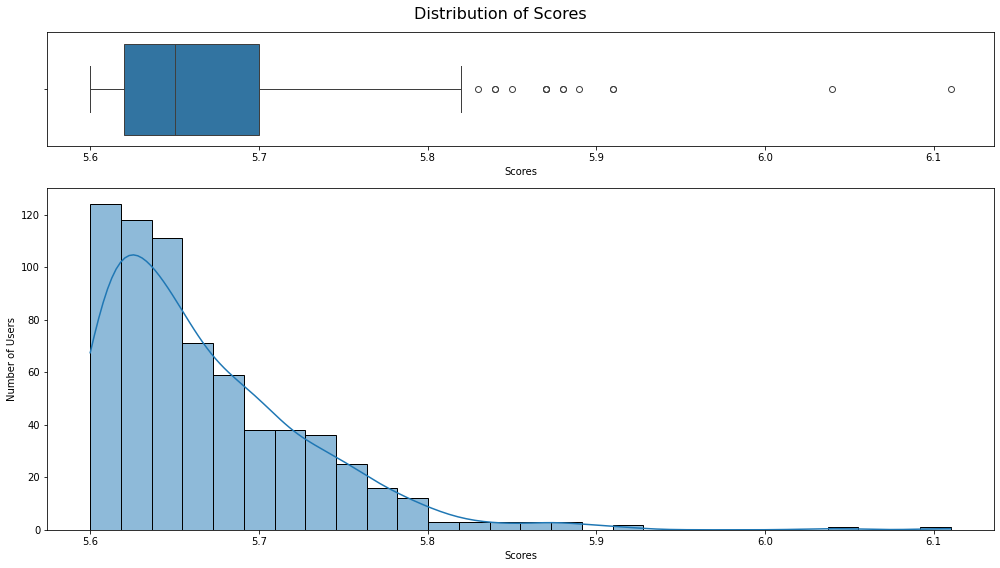

In [23]:
# Function to plot a histogram with 10 bins
def plotHistogram(column, title, xLabel, yLabel, rotateLabels=False, bigChart=False):
    if bigChart:
        plt.figure(figsize = (20, 7))
    else:
        plt.figure(figsize = (12, 4))
 
    sns.histplot(column, bins=10, kde=False)

    plt.tick_params(labelsize = 10)
    plt.title(title, fontsize = 16)
    plt.xlabel(xLabel, fontsize = 10)
    plt.ylabel(yLabel, fontsize = 10)

    if rotateLabels:
        plt.xticks(rotation=45)

    plt.show()


# Defining the hist_box() function
def hist_box(data, col, title, xLabel, yLabel):
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 3]})

    # Horizontal boxplot
    sns.boxplot(data=data, x=col, orient="h", ax=axes[0])
    axes[0].set_xlabel(xLabel)

    # Distribution plot
    sns.histplot(data[col], kde=True, ax=axes[1])
    axes[1].set_xlabel(xLabel)
    axes[1].set_ylabel(yLabel)

    # Set the general title for the figure
    fig.suptitle(title, fontsize=16)

    # Display the plots
    plt.tight_layout()
    plt.show()

hist_box(users_df, 'score', "Distribution of Scores", "Scores", "Number of Users")


We can notice that most users have credit scores between 5.6 and 5.8 with some outliers greater than 6.0. The distribution is right-skewed.

Let's check the credit limit.

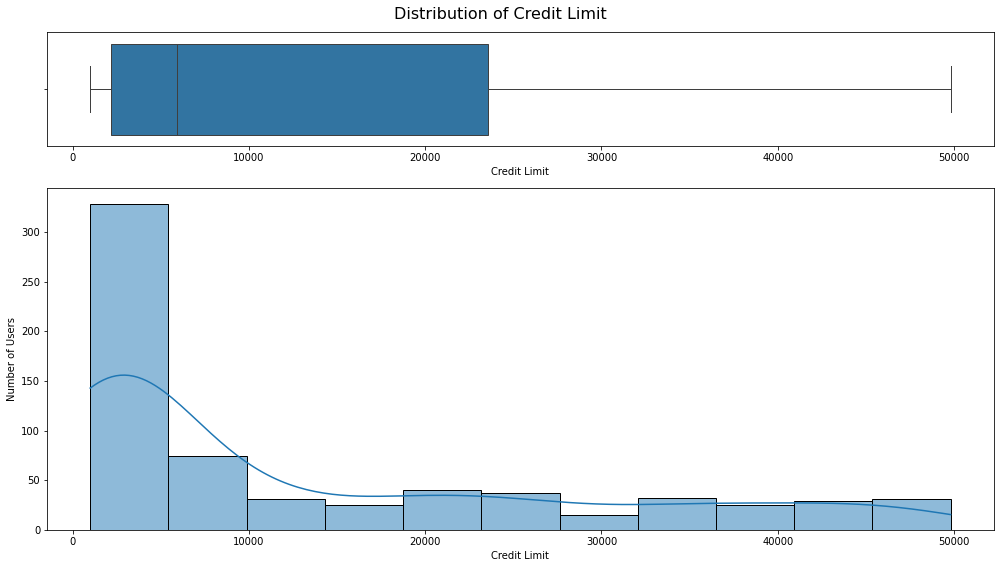

5900.0

In [246]:
hist_box(users_df, 'credit_limit', "Distribution of Credit Limit", "Credit Limit", "Number of Users")
users_df['credit_limit'].median()

We can notice that most users have a low credit limit, with a median of 5900.00.

Let's check the interest rate.

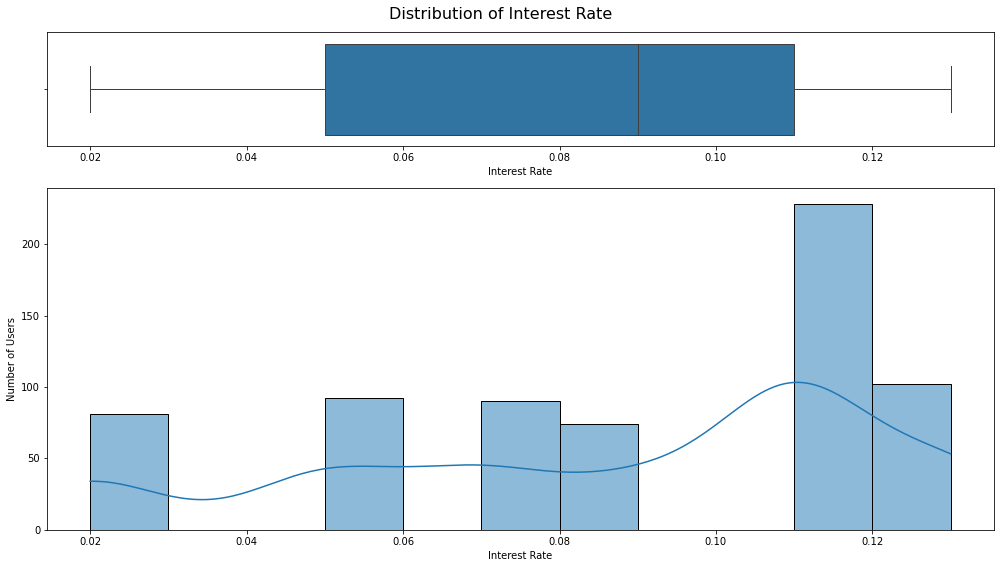

   interest_rate  number_of_users
0           0.02               81
1           0.05               92
2           0.07               90
3           0.09               74
4           0.11              228
5           0.13              102


In [24]:
hist_box(users_df, 'interest_rate', 'Distribution of Interest Rate', 'Interest Rate', 'Number of Users')

users_df_interest_rates = users_df.groupby('interest_rate').count().reset_index()
users_df_interest_rates.rename(columns={'user_id': 'number_of_users'}, inplace=True)
print(users_df_interest_rates[['interest_rate', 'number_of_users']])

Most users have an interest rate of 11%. But some users have a very low interest rate of only 2%.

Let's check loan terms.

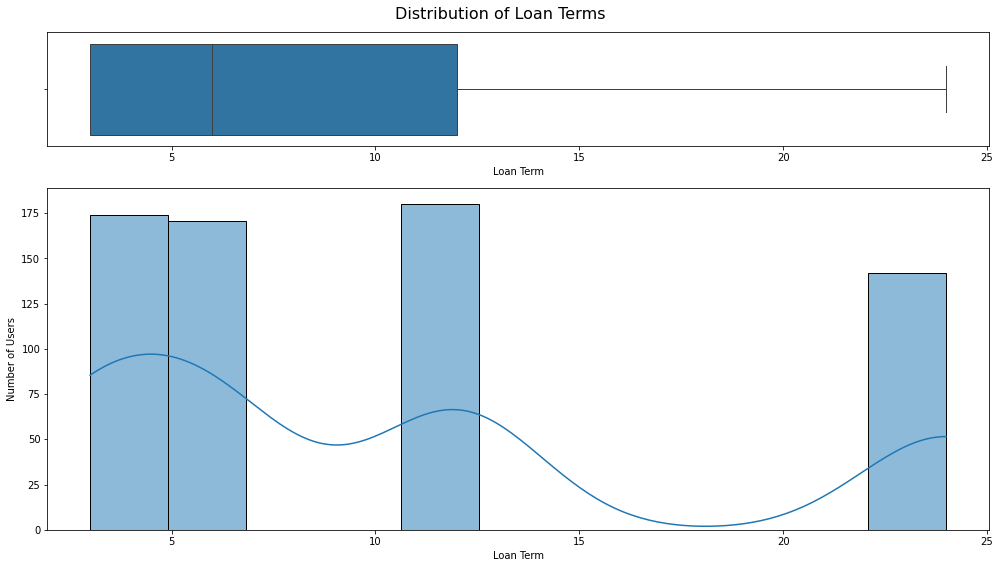

   loan_term  number_of_users
0        3.0              174
1        6.0              171
2       12.0              180
3       24.0              142


In [25]:
hist_box(users_df, 'loan_term', 'Distribution of Loan Terms', 'Loan Term', 'Number of Users')

users_df_loan_terms = users_df.groupby('loan_term').count().reset_index()
users_df_loan_terms.rename(columns={'user_id': 'number_of_users'}, inplace=True)
print(users_df_loan_terms[['loan_term', 'number_of_users']])

From the above, we can notice that there are only four loan terms: 3, 6, 12, and 24 months. There is almost the same number of users for each term.

Let's check how the number of approved and denied loans have varied over time.

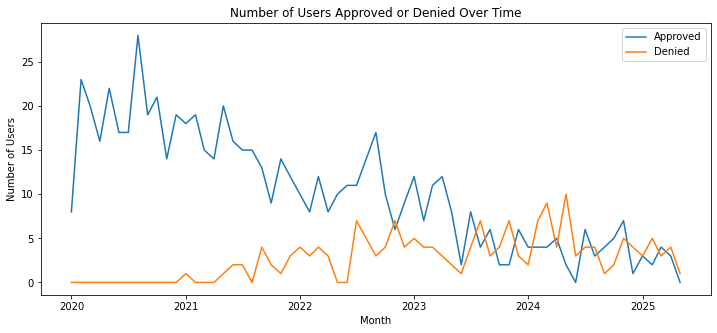

In [26]:
# Convert the columns to datetime
users_df['approved_date'] = pd.to_datetime(users_df['approved_date'])
users_df['denied_date'] = pd.to_datetime(users_df['denied_date'])

# Making a copy so the original dataset is not modified
users_df2 = users_df.copy()

# Creating columns for the month when the loan was approved or rejected
users_df2['approved_month'] = users_df2['approved_date'].dt.to_period('M').dt.to_timestamp()
users_df2['denied_month'] = users_df2['denied_date'].dt.to_period('M').dt.to_timestamp()

# Counting the number of approvals each month
approved_counts = users_df2['approved_month'].dropna().value_counts().sort_index().reset_index()
approved_counts.columns = ['month', 'approved_count']

# Counting the number of denials each month
denied_counts = users_df2['denied_month'].dropna().value_counts().sort_index().reset_index()
denied_counts.columns = ['month', 'denied_count']

# Merging the two dataframes
counts = pd.merge(approved_counts, denied_counts, on='month', how='outer').fillna(0)
counts['approved_count'] = counts['approved_count'].astype(int)
counts['denied_count'] = counts['denied_count'].astype(int)

# Plotting a line chart with a line for approved and another for denied loans
plt.figure(figsize=(12, 5))
sns.lineplot(data=counts, x='month', y='approved_count', label='Approved')
sns.lineplot(data=counts, x='month', y='denied_count', label='Denied')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.title('Number of Users Approved or Denied Over Time')
plt.legend()
plt.show()


From the above, we can notice that the number of approved loans has lowered in the last years, while the number of denied loans increased a bit.

Let's check if there are cases where both the accepted and the denied date are filled.

In [27]:
print(users_df.dropna(subset=['approved_date', 'denied_date']))

# Filter cases where approved_date > denied_date
approved_greater = users_df[users_df['approved_date'] > users_df['denied_date']]

# Filter cases where approved_date < denied_date
approved_lesser = users_df[users_df['approved_date'] < users_df['denied_date']]

# Count the number of cases for each condition
count_approved_greater = approved_greater.shape[0]
count_approved_lesser = approved_lesser.shape[0]

print(f"Number of cases where approved_date > denied_date: {count_approved_greater}")
print(f"Number of cases where approved_date < denied_date: {count_approved_lesser}")

     user_id  score approved_date denied_date  credit_limit  interest_rate  \
2          3   5.61    2023-12-04  2025-04-26        9500.0           0.09   
13        14   5.61    2021-07-03  2024-11-13        1300.0           0.11   
16        17   5.62    2020-08-14  2022-07-04        1200.0           0.11   
21        22   5.64    2021-07-25  2024-11-05        2300.0           0.13   
27        28   5.69    2020-06-30  2024-02-09       21200.0           0.02   
..       ...    ...           ...         ...           ...            ...   
695      696   5.68    2020-08-28  2024-06-07       43800.0           0.07   
719      720   5.62    2020-03-16  2024-02-23        1100.0           0.13   
724      725   5.74    2022-05-17  2024-04-05       20900.0           0.05   
726      727   5.62    2021-09-01  2022-11-24        1900.0           0.13   
728      729   5.63    2021-09-14  2022-11-07        1600.0           0.11   

     loan_term  
2          6.0  
13         3.0  
16         3

There is a significant amount of users with both approved_date and denied_date filled. In all cases, the denied_date is greater than the approved_date.

### Emotional Data

Looking at the first rows:

In [193]:
emotion_df.head()

,user_id,timestamp,intensity,time_of_day,primary_emotion,relationship,situation,location,weather,physical_state,preceding_event,grade
0,1,2019-04-07 22:50:39,4.0,night,anticipation,None,cooking,None,cloudy,energetic,criticism,3.72
1,1,2019-04-07 14:02:53,9.0,afternoon,boredom,parent,volunteering,home,snowy,None,good news,4.79
2,1,2019-04-07 03:16:21,7.0,night,shame,neighbor,in meeting,work,sunny,tired,None,2.94
3,1,2019-04-08 17:10:35,5.0,evening,joy,stranger,argument,None,windy,rested,compliment,5.35
4,1,2019-04-08 16:12:02,1.0,afternoon,joy,child,clothes shopping,None,sunny,None,surprise,2.97


Checking the existing columns:

In [194]:
emotion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440948 entries, 0 to 2440947
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          int64  
 1   timestamp        object 
 2   intensity        float64
 3   time_of_day      object 
 4   primary_emotion  object 
 5   relationship     object 
 6   situation        object 
 7   location         object 
 8   weather          object 
 9   physical_state   object 
 10  preceding_event  object 
 11  grade            float64
dtypes: float64(2), int64(1), object(9)
memory usage: 223.5+ MB


Checking the shape:

In [195]:
emotion_df.shape

(2440948, 12)

Checking the number of null values in each column:

In [196]:
print(emotion_df.isnull().sum())

user_id                 0
timestamp               0
intensity               0
time_of_day             0
primary_emotion         0
relationship       561367
situation          560784
location           560021
weather            559959
physical_state     562260
preceding_event    561935
grade                   0
dtype: int64


From the above, we learn that there are more than 2 million rows of emotional data to be explored and categorized. Almost 25% of these records don't have information about relationship, situation, location, weather, physical state and the preceding event.

Let's check intensity and its distribution.

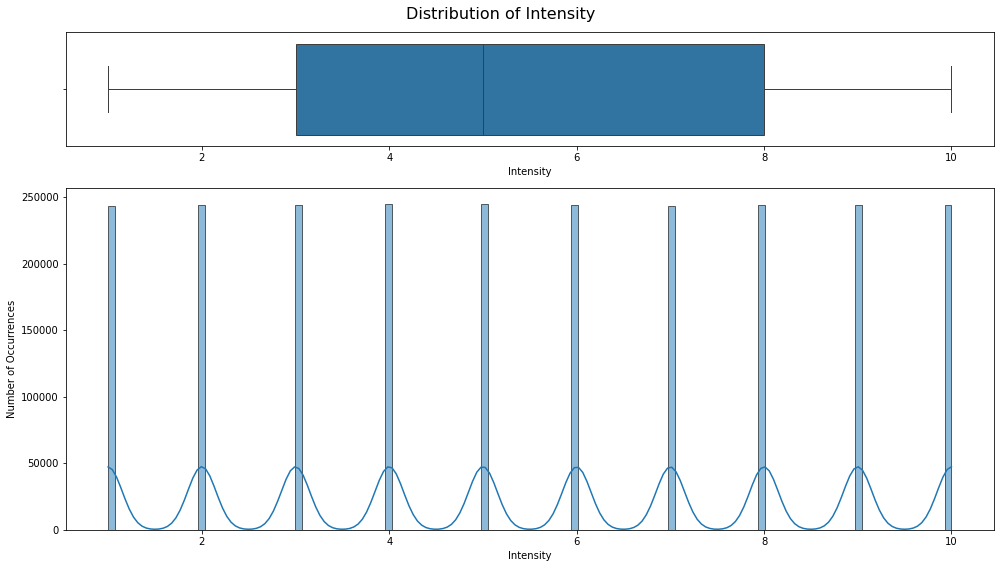

In [257]:
hist_box(emotion_df, 'intensity', "Distribution of Intensity", "Intensity", "Number of Occurrences")

We can notice that the intensity ranges from 1 to 10 and is evenly distributed across occurrences.

Let's check time of day.

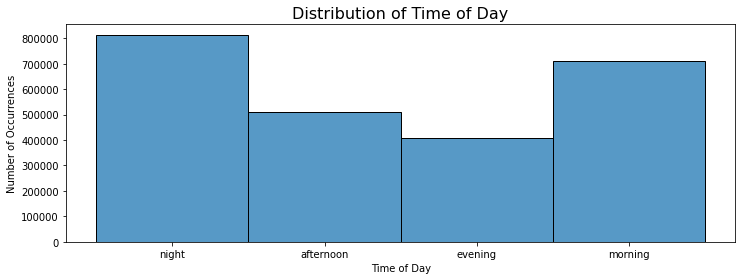

In [260]:
plotHistogram(emotion_df['time_of_day'], "Distribution of Time of Day", "Time of Day", "Number of Occurrences")


Most records are in the night and in the morning.

Let's check the primary emotion.

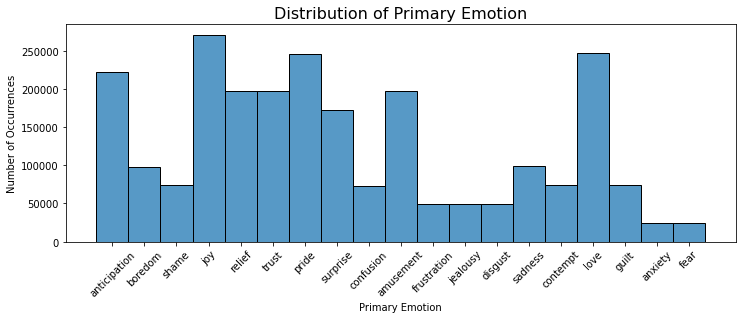

In [261]:
plotHistogram(emotion_df['primary_emotion'], "Distribution of Primary Emotion", "Primary Emotion", "Number of Occurrences", rotateLabels=True)

There is a wide variety of emotions and some of them have a higher frequency.

Let's check relationships.

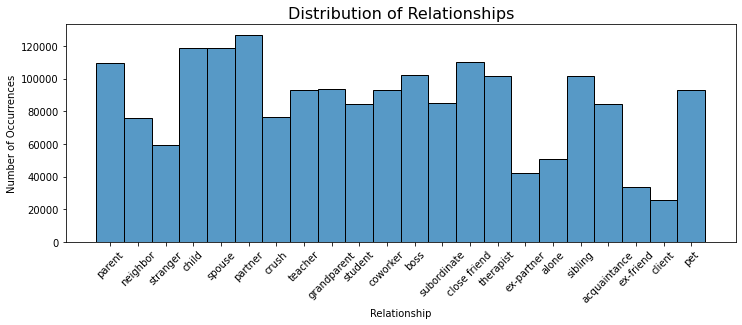

In [262]:
plotHistogram(emotion_df['relationship'], "Distribution of Relationships", "Relationship", "Number of Occurrences", rotateLabels=True)

There is also a wide range of relationships with different frequencies.

Let's check the situation.

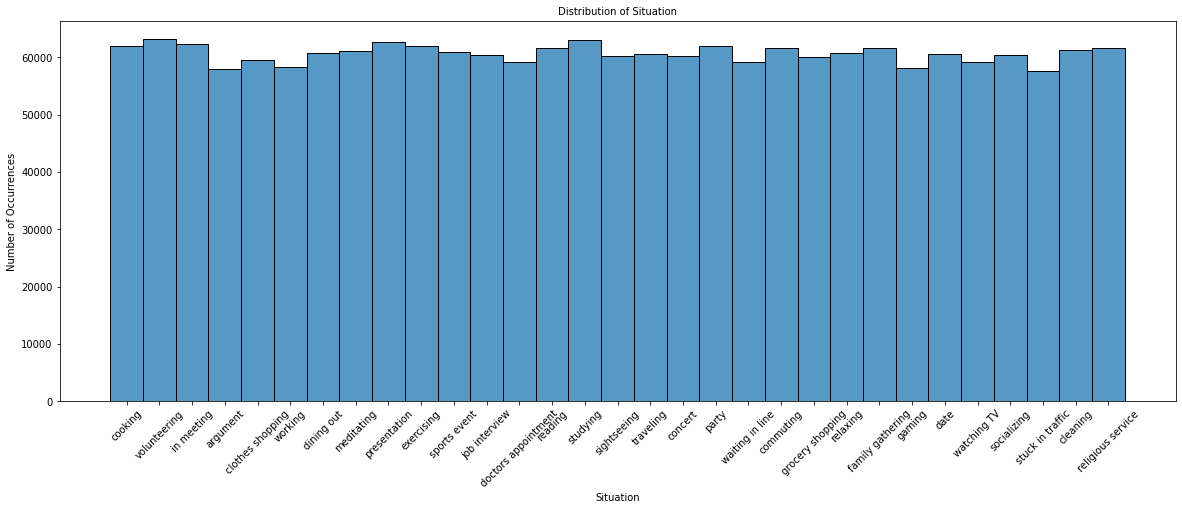

In [202]:
plotHistogram(emotion_df['situation'], "Distribution of Situation", "Situation", "Number of Occurrences", rotateLabels=True, bigChart=True)

There is also several different situations and they are evenly distributed.

Let's check the location.

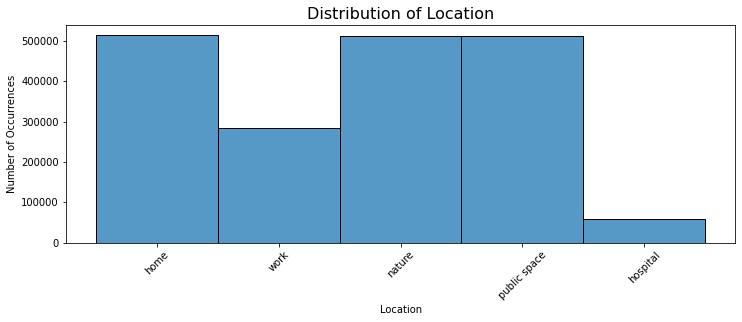

In [263]:
plotHistogram(emotion_df['location'], "Distribution of Location", "Location", "Number of Occurrences", rotateLabels=True)

The locations with higher frequency are home, nature, and public space.

Let's check weather.

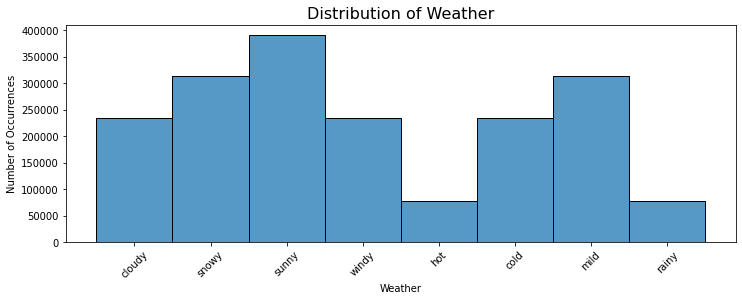

In [264]:
plotHistogram(emotion_df['weather'], "Distribution of Weather", "Weather", "Number of Occurrences", rotateLabels=True)

The most frequent weather conditions are sunny, snowy, and mild.

Let's check the physical state.

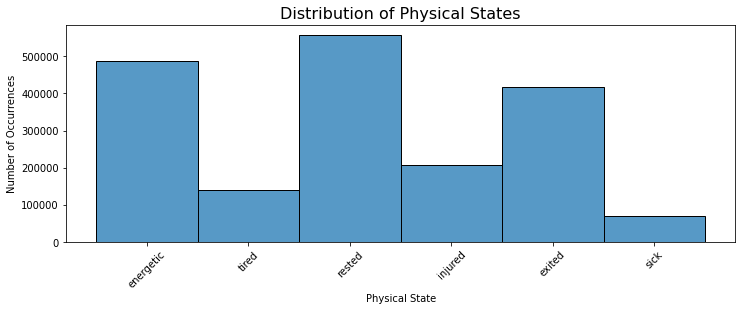

In [265]:
plotHistogram(emotion_df['physical_state'], "Distribution of Physical States", "Physical State", "Number of Occurrences", rotateLabels=True)

The most common physical states are rested and energetic.

Finally, let's check the preceding events.

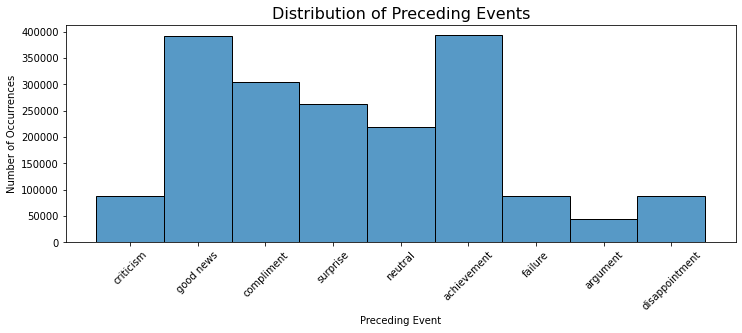

In [266]:
plotHistogram(emotion_df['preceding_event'], "Distribution of Preceding Events", "Preceding Event", "Number of Occurrences", rotateLabels=True)

The most common preceding events are good news and achievement.

### Loans

Looking at the first rows:

In [207]:
loans_df.head()

,loan_id,user_id,loan_amount,total_amount,issue_date,due_date,paid_date,installment_amount,loan_amount_paid,status
0,1,1,29955,47928.00,2021-06-14,2022-06-09,2021-10-05,3994.00,35596.53,paid
1,2,1,15473,24756.80,2022-12-06,2023-12-01,2023-08-17,2063.07,22023.24,paid
2,3,1,15781,25249.60,2025-04-24,2026-04-19,2025-04-28,2104.13,15886.21,paid
3,4,3,8715,13421.10,2024-10-28,2025-04-26,None,2236.85,0.00,late
4,5,4,1721,2288.93,2021-03-09,2021-06-07,2021-03-29,762.98,1847.21,paid


Checking the existing columns:

In [208]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_id             1188 non-null   int64  
 1   user_id             1188 non-null   int64  
 2   loan_amount         1188 non-null   int64  
 3   total_amount        1188 non-null   float64
 4   issue_date          1188 non-null   object 
 5   due_date            1188 non-null   object 
 6   paid_date           947 non-null    object 
 7   installment_amount  1188 non-null   float64
 8   loan_amount_paid    1188 non-null   float64
 9   status              1188 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 92.9+ KB


Checking the shape:

In [209]:
loans_df.shape

(1188, 10)

From the above, we can see that there is a history of 1188 loans, some of which have not been paid yet.
Let's take a look at the loan amount.

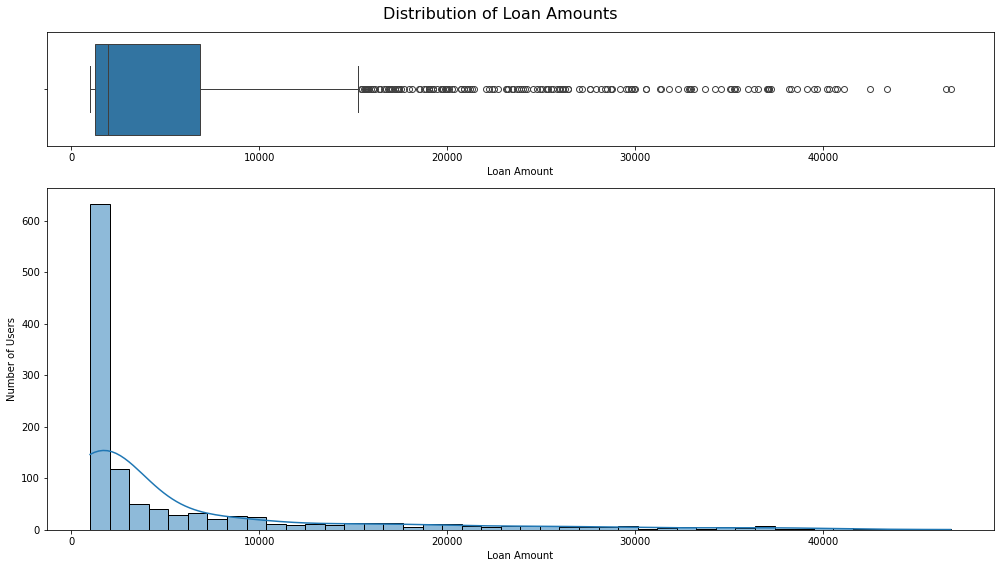

1945.0

In [269]:
hist_box(loans_df, 'loan_amount', "Distribution of Loan Amounts", "Loan Amount", "Number of Users")
loans_df['loan_amount'].median()

We can notice that the median loan amount is 1,945. There are also outliers well above 40,000.

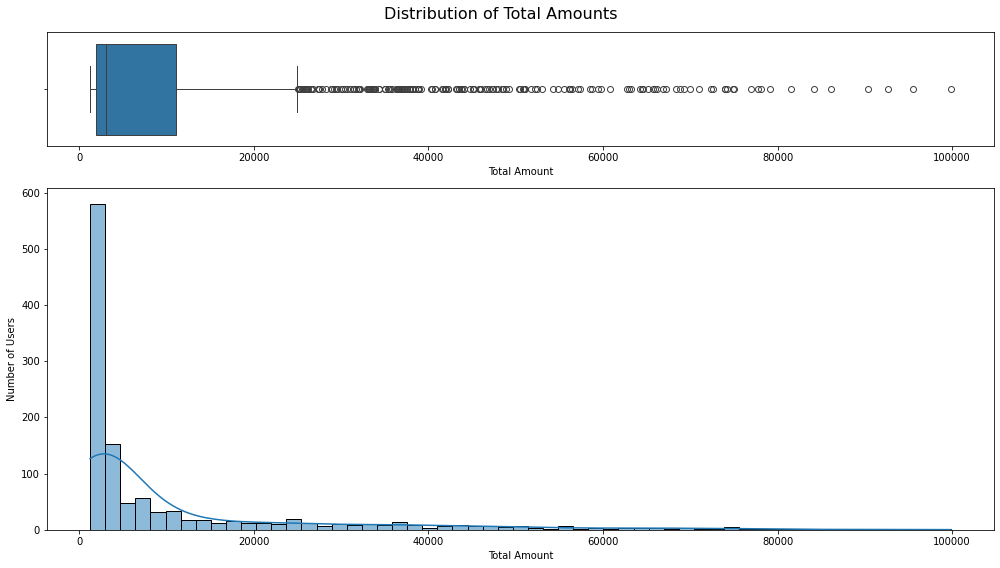

3058.215

In [270]:
hist_box(loans_df, 'total_amount', "Distribution of Total Amounts", "Total Amount", "Number of Users")
loans_df['total_amount'].median()


The median total amount is 3,058. But there are some outliers reaching 100,000.

Let's check the amount paid.

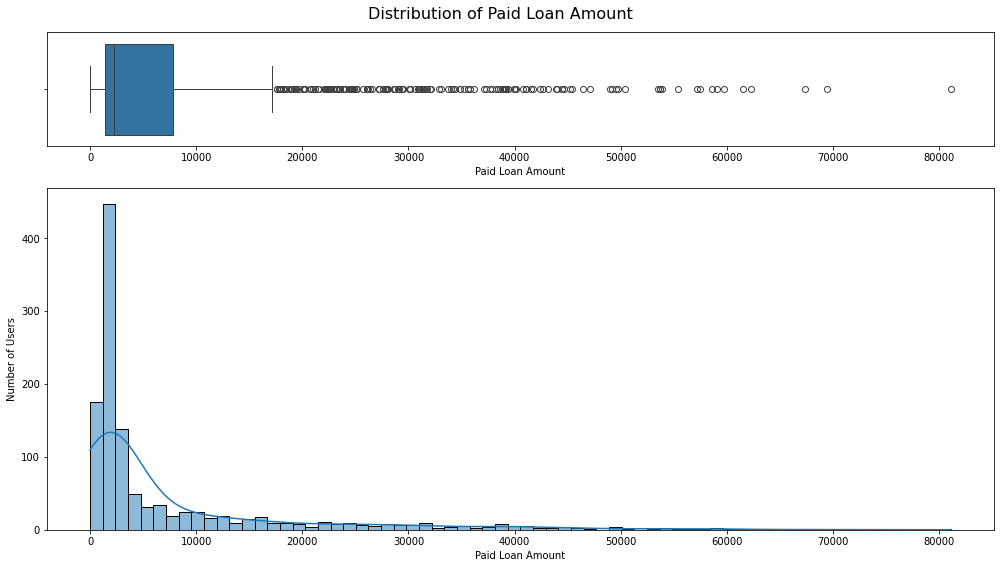

2247.15

In [272]:
hist_box(loans_df, 'loan_amount_paid', "Distribution of Paid Loan Amount", "Paid Loan Amount", "Number of Users")
loans_df['loan_amount_paid'].median()

The paid loan amount distribution is similar to the total amount distribution, what is expected.

Let's check the loan statuses.

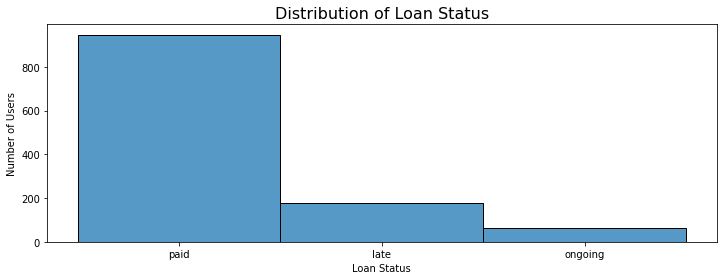

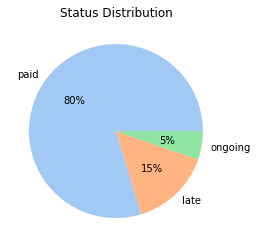

In [28]:
plotHistogram(loans_df['status'], "Distribution of Loan Status", "Loan Status", "Number of Users")

# Count occurrences of each status
status_counts = loans_df['status'].value_counts()
colors = sns.color_palette('pastel')[0:len(status_counts)]

# Create pie chart
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%.0f%%')
plt.title('Status Distribution')
plt.show()

We can notice that most users have paid their loans, with 15% being late.

Let's check how many loans per user are taken.

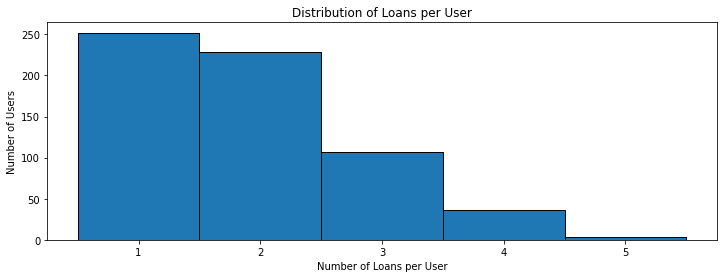

In [29]:
# Count the number of loans per user
loan_counts = loans_df['user_id'].value_counts()

plt.figure(figsize = (12, 4))
plt.hist(loan_counts, bins=range(1, loan_counts.max() + 2), edgecolor='black', align='left')
plt.xlabel('Number of Loans per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Loans per User')
plt.xticks(range(1, loan_counts.max() + 1))
plt.show()

As expected, most users have only taken one loan and only a few have taken 5.

Let's check the installment amounts.

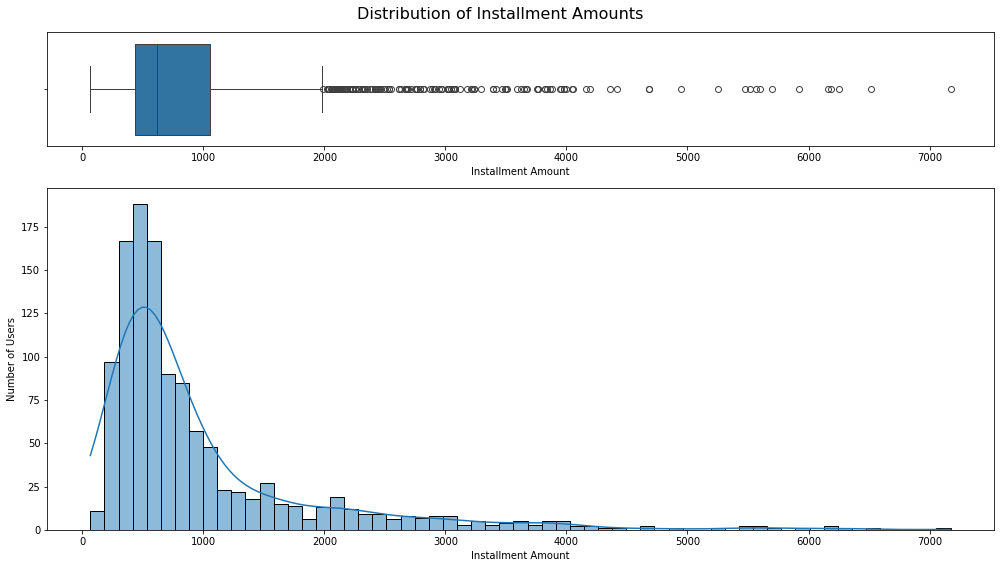

614.61

In [30]:
hist_box(loans_df, 'installment_amount', "Distribution of Installment Amounts", "Installment Amount", "Number of Users")
loans_df['installment_amount'].median()

The median installment amount is 614,61. There are some outliers greater than 7,000.

## **Emotional Pattern Analysis**

### Dominant emotional patterns over time

To understand which emotions dominate most users and how they vary over time, let's start by grouping the data by month. For each month, we calculate the importance of each emotion. The importance is defined as the number of users who felt a specific emotion times the average intensity. We then plot a line chart that shows how the importance of each emotion varies over time.

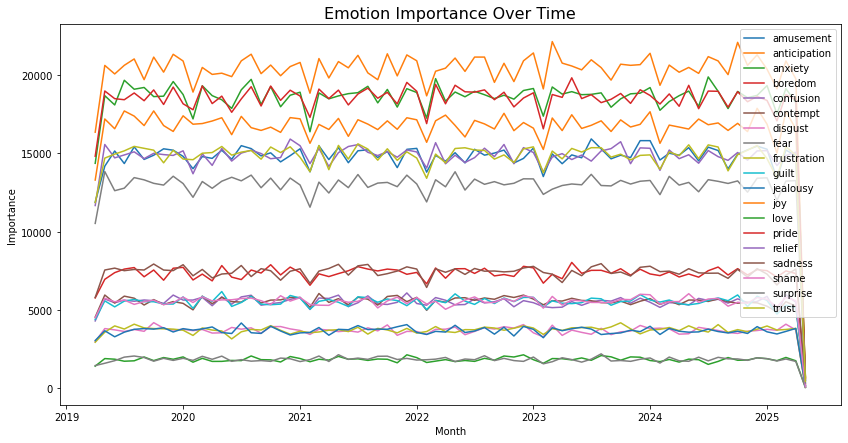

In [31]:
emotion_df2 = emotion_df.copy()
emotion_df2 = emotion_df2[['timestamp', 'primary_emotion', 'intensity', 'user_id']]

# Convert timestamp to datetime
emotion_df2['timestamp'] = pd.to_datetime(emotion_df2['timestamp'], errors='coerce')

# Ensure primary_emotion is a string
emotion_df2['primary_emotion'] = emotion_df2['primary_emotion'].astype(str)

# Check for any NaT values in timestamp and drop them
emotion_df2 = emotion_df2.dropna(subset=['timestamp'])

# Extract the month from the timestamp
emotion_df2['month'] = emotion_df2['timestamp'].dt.to_period('M').apply(lambda r: r.start_time)

# Group by month and primary_emotion, then calculate the mean intensity and count of users
grouped_df = emotion_df2.groupby(['month', 'primary_emotion']).agg(
    mean_intensity=('intensity', 'mean'),
    user_count=('user_id', 'count')
).reset_index()

# Convert 'month' to datetime for plotting
grouped_df['month'] = pd.to_datetime(grouped_df['month'])

# Calculate the importance
grouped_df['importance'] = grouped_df['mean_intensity'] * grouped_df['user_count']

# Pivot the data to have emotions as columns
pivot_df = grouped_df.pivot(index='month', columns='primary_emotion', values='importance')

plt.figure(figsize=(14, 7))

for emotion in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[emotion], label=emotion)

plt.xlabel('Month', fontsize = 10)
plt.ylabel('Importance', fontsize = 10)
plt.title('Emotion Importance Over Time', fontsize = 16)
plt.legend()
plt.show()

The chart above shows that emotions frequency do not vary a lot over time. Let's isolate the five more important ones.

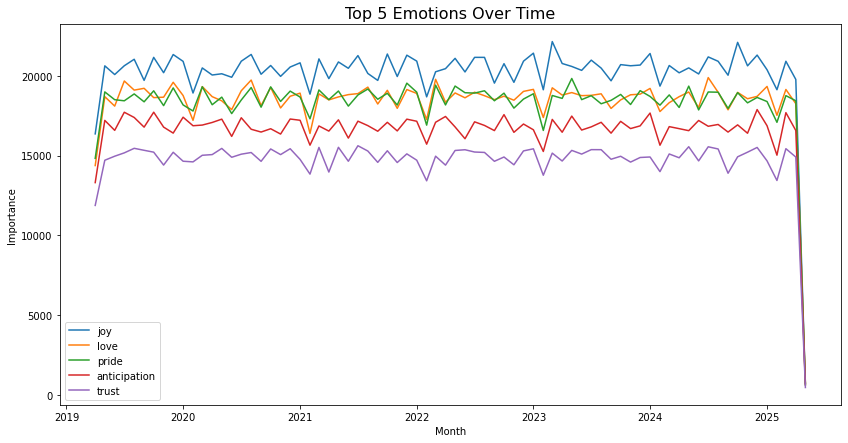

In [32]:
# Calculate the average importance for each emotion
average_importance = pivot_df.mean().sort_values(ascending=False)

# Select the top 5 emotions with the highest average importance
top_5_emotions = average_importance.head(5).index

plt.figure(figsize=(14, 7))

# Plot only the top 5 emotions
for emotion in top_5_emotions:
    plt.plot(pivot_df.index, pivot_df[emotion], label=emotion)

plt.xlabel('Month', fontsize = 10)
plt.ylabel('Importance', fontsize = 10)
plt.title('Top 5 Emotions Over Time', fontsize = 16)
plt.legend()
plt.show()

We can now identify the most important emotions: joy, love, pride, anticipation, and trust.

### Correlation between emotions and other data

By analyzing the correlation among variables, we may find interesting patterns that will give more insights into the data.

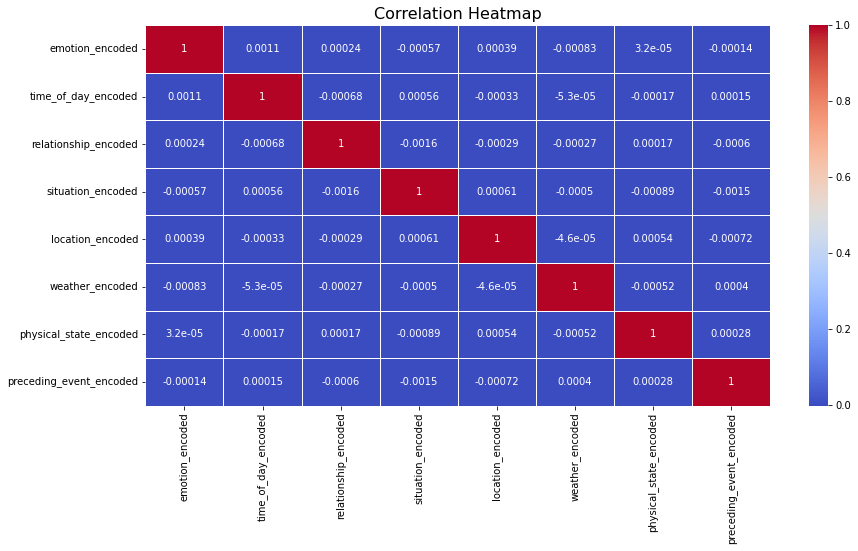

In [33]:
emotion_df['timestamp'] = pd.to_datetime(emotion_df2['timestamp'], errors='coerce')

# Encode the categorical variables using numeric values
label_encoder = LabelEncoder()
emotion_df['emotion_encoded'] = label_encoder.fit_transform(emotion_df['primary_emotion'])
emotion_df['time_of_day_encoded'] = label_encoder.fit_transform(emotion_df['time_of_day'])
emotion_df['relationship_encoded'] = label_encoder.fit_transform(emotion_df['relationship'])
emotion_df['situation_encoded'] = label_encoder.fit_transform(emotion_df['situation'])
emotion_df['location_encoded'] = label_encoder.fit_transform(emotion_df['location'])
emotion_df['weather_encoded'] = label_encoder.fit_transform(emotion_df['weather'])
emotion_df['physical_state_encoded'] = label_encoder.fit_transform(emotion_df['physical_state'])
emotion_df['preceding_event_encoded'] = label_encoder.fit_transform(emotion_df['preceding_event'])

# Select only the encoded columns
emotion_corr_df = emotion_df[['emotion_encoded', 'time_of_day_encoded', 'relationship_encoded', 'situation_encoded', 'location_encoded', 'weather_encoded', 'physical_state_encoded', 'preceding_event_encoded']]

# Calculate the correlation matrix
corr_matrix = emotion_corr_df.corr()

# Display a heatmap with correlations
plt.figure(figsize=(14, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize = 16)
plt.show()

From the above, we can notice that there is no correlation among the variables.

### Loan-Emotion Correlation

To check if there is any relationship between the emotions and the loan terms, let's first first combine the users and the loans dataframes by associating each user with the latest approved loan.

In [34]:
# Get the latest loan for each user
latest_loans = loans_df.loc[loans_df.groupby('user_id')['issue_date'].idxmax()]

# Merge the dataframes
merged_df = pd.merge(users_df, latest_loans, on='user_id')

# Drop unnecessary columns
merged_df.drop(columns=['denied_date'], inplace=True)

merged_df.head()

,user_id,score,approved_date,credit_limit,interest_rate,loan_term,loan_id,loan_amount,total_amount,issue_date,due_date,paid_date,installment_amount,loan_amount_paid,status
0,1,5.69,2020-05-21,32700.0,0.05,12.0,3,15781,25249.60,2025-04-24,2026-04-19,2025-04-28,2104.13,15886.21,paid
1,3,5.61,2023-12-04,9500.0,0.09,6.0,4,8715,13421.10,2024-10-28,2025-04-26,None,2236.85,0.00,late
2,4,5.64,2020-05-14,1800.0,0.11,3.0,8,1794,2386.02,2025-02-16,2025-05-17,2025-03-24,795.34,2030.81,paid
3,5,5.64,2021-04-29,1700.0,0.11,3.0,12,1592,2117.36,2025-04-07,2025-07-06,None,705.79,0.00,ongoing
4,6,5.79,2021-04-03,20000.0,0.05,24.0,14,10467,23027.40,2025-03-12,2027-03-02,2025-03-14,959.48,10501.89,paid


In [293]:
merged_df.shape

(626, 15)

Now, let's capture the latest emotion recorded before the loan was issued.

In [35]:
# Convert issue_date and timestamp to datetime
merged_df['issue_date'] = pd.to_datetime(merged_df['issue_date'])
emotion_df['timestamp'] = pd.to_datetime(emotion_df['timestamp'])

# emotion_df.head()

# Function to get the latest emotion before issue_date
def get_latest_emotion(user_id, issue_date):
    user_emotions = emotion_df[(emotion_df['user_id'] == user_id) & (emotion_df['timestamp'] < issue_date)]
    if not user_emotions.empty:
        return user_emotions.loc[user_emotions['timestamp'].idxmax()]
    else:
        return pd.Series()

# Apply the function to get the latest emotion for each row in merged_df
latest_emotions = merged_df.apply(lambda row: get_latest_emotion(row['user_id'], row['issue_date']), axis=1)

# Concatenate the latest emotions with the merged dataframe
final_df = pd.concat([merged_df.reset_index(drop=True), latest_emotions.reset_index(drop=True)], axis=1)
final_df.head()

,user_id,score,approved_date,credit_limit,interest_rate,loan_term,loan_id,loan_amount,total_amount,issue_date,...,preceding_event,grade,emotion_encoded,time_of_day_encoded,relationship_encoded,situation_encoded,location_encoded,weather_encoded,physical_state_encoded,preceding_event_encoded
0,1,5.69,2020-05-21,32700.0,0.05,12.0,3,15781,25249.60,2025-04-24,...,compliment,6.98,0,0,0,10,5,3,4,2
1,3,5.61,2023-12-04,9500.0,0.09,6.0,4,8715,13421.10,2024-10-28,...,surprise,2.02,16,0,17,22,0,5,3,8
2,4,5.64,2020-05-14,1800.0,0.11,3.0,8,1794,2386.02,2025-02-16,...,compliment,6.73,12,2,0,4,2,5,3,2
3,5,5.64,2021-04-29,1700.0,0.11,3.0,12,1592,2117.36,2025-04-07,...,None,3.47,5,1,22,31,0,6,5,9
4,6,5.79,2021-04-03,20000.0,0.05,24.0,14,10467,23027.40,2025-03-12,...,None,5.02,14,0,9,31,2,1,1,9


Now, let's check if there is any correlation between the emotion and the loan terms.

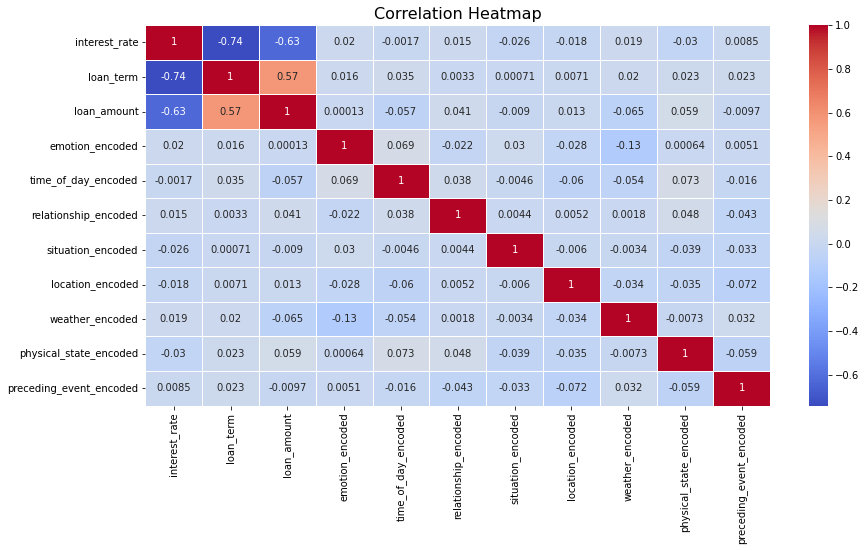

In [36]:
final_df_corr = final_df[['interest_rate', 'loan_term', 'loan_amount', 'emotion_encoded', 'time_of_day_encoded', 'relationship_encoded', 'situation_encoded', 'location_encoded', 'weather_encoded', 'physical_state_encoded', 'preceding_event_encoded']]

# Calculate the correlation matrix
corr_matrix = final_df_corr.corr()

# Display a heatmap with correlations
plt.figure(figsize=(14, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

There is also no correlation between the emotion and the loan terms. The only correlation is among the loan terms.

Let's convert the categorical columns to binary columns to further analyze the relationship among them.

In [296]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  626 non-null    int64         
 1   score                    626 non-null    float64       
 2   approved_date            626 non-null    object        
 3   credit_limit             626 non-null    float64       
 4   interest_rate            626 non-null    float64       
 5   loan_term                626 non-null    float64       
 6   loan_id                  626 non-null    int64         
 7   loan_amount              626 non-null    int64         
 8   total_amount             626 non-null    float64       
 9   issue_date               626 non-null    datetime64[ns]
 10  due_date                 626 non-null    object        
 11  paid_date                385 non-null    object        
 12  installment_amount       626 non-nul

In [37]:
# Convert the categorical columns to dummy variables
df_binary = pd.get_dummies(final_df, columns=['primary_emotion', 'time_of_day', 'relationship', 'situation', 'location', 'weather', 'physical_state', 'preceding_event'])
pd.set_option('display.max_columns', None)
for column in df_binary.columns:
    print(column)

user_id
score
approved_date
credit_limit
interest_rate
loan_term
loan_id
loan_amount
total_amount
issue_date
due_date
paid_date
installment_amount
loan_amount_paid
status
user_id
timestamp
intensity
grade
emotion_encoded
time_of_day_encoded
relationship_encoded
situation_encoded
location_encoded
weather_encoded
physical_state_encoded
preceding_event_encoded
primary_emotion_amusement
primary_emotion_anticipation
primary_emotion_anxiety
primary_emotion_boredom
primary_emotion_confusion
primary_emotion_contempt
primary_emotion_disgust
primary_emotion_fear
primary_emotion_frustration
primary_emotion_guilt
primary_emotion_jealousy
primary_emotion_joy
primary_emotion_love
primary_emotion_pride
primary_emotion_relief
primary_emotion_sadness
primary_emotion_shame
primary_emotion_surprise
primary_emotion_trust
time_of_day_afternoon
time_of_day_evening
time_of_day_morning
time_of_day_night
relationship_acquaintance
relationship_alone
relationship_boss
relationship_child
relationship_client
relat

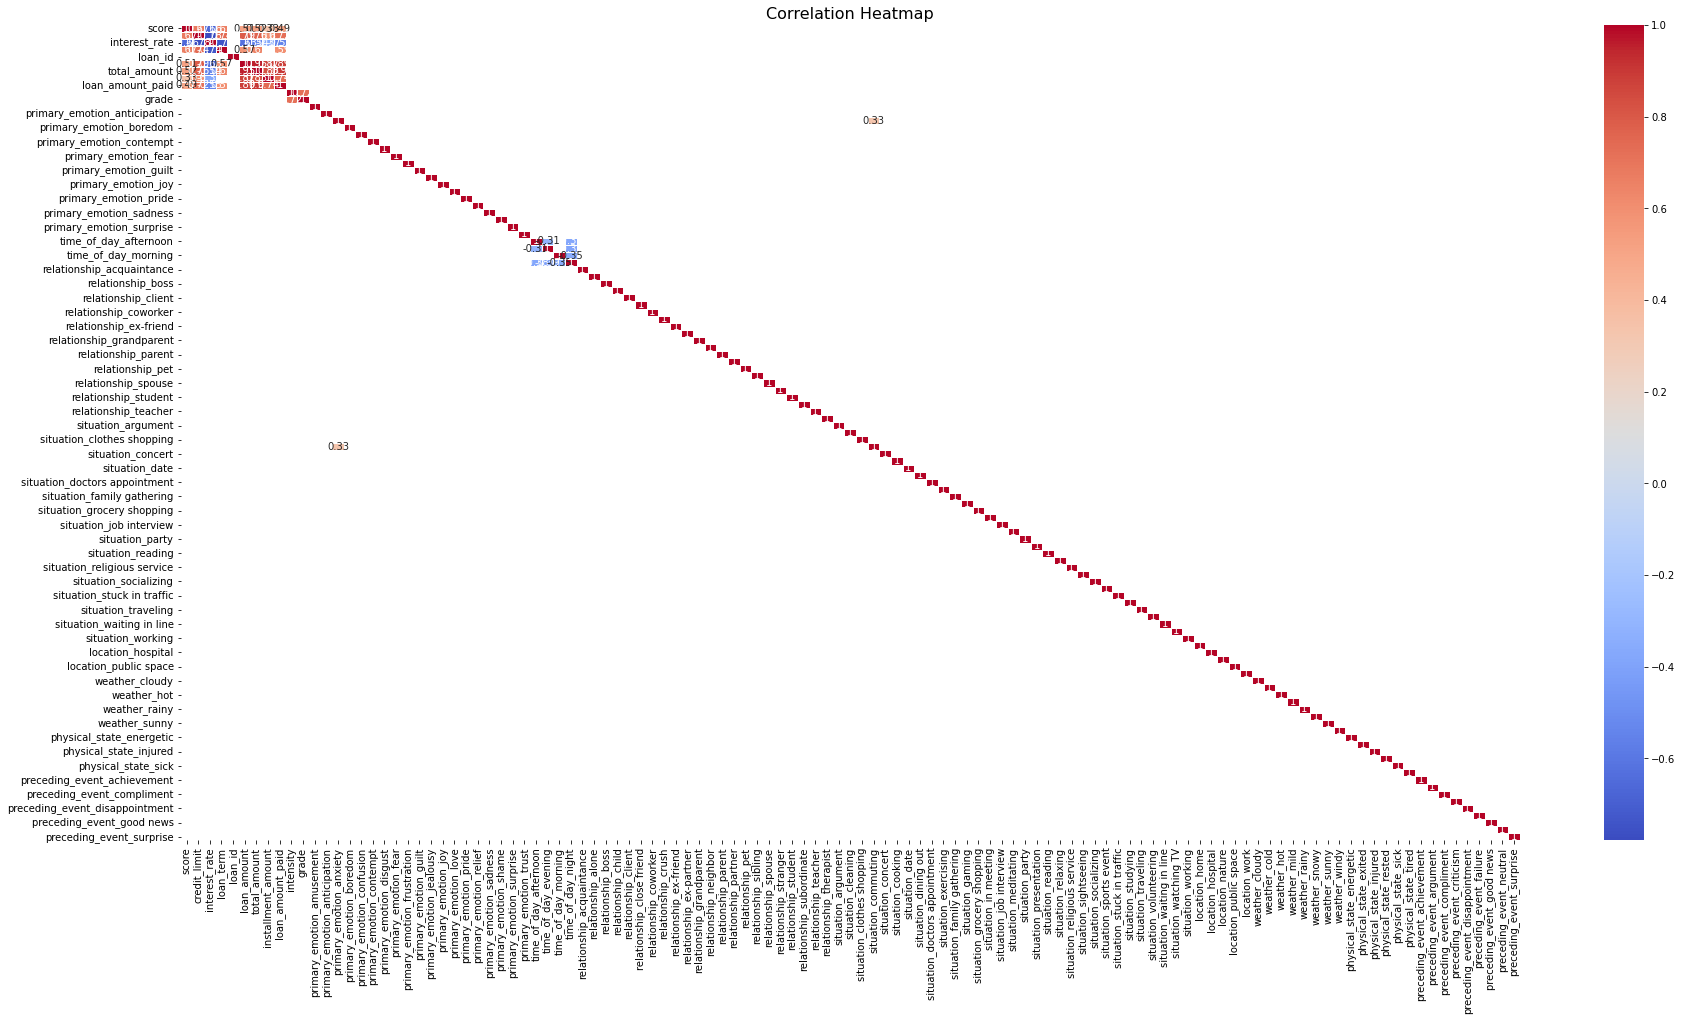

In [38]:
df_binary_corr = df_binary.drop(['user_id', 'approved_date', 'timestamp', 'issue_date', 'due_date', 'paid_date', 'status', 'emotion_encoded', 'time_of_day_encoded', 'relationship_encoded', 'situation_encoded', 'location_encoded', 'weather_encoded', 'physical_state_encoded', 'preceding_event_encoded'], axis=1)

# Calculate the correlation matrix
corr_matrix_binary = df_binary_corr.corr()

# Filter the correlation matrix to show only relevant values
threshold = 0.3
corr_matrix_binary = corr_matrix_binary[(corr_matrix_binary >= threshold) | (corr_matrix_binary <= -threshold)]

# Drop rows and columns that are all NaN
corr_matrix_binary = corr_matrix_binary.dropna(how='all').dropna(axis=1, how='all')

# Display a heatmap with correlations
plt.figure(figsize=(30, 15))
sns.heatmap(corr_matrix_binary, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

We can see from the above that there is strong correlation only among score and loan terms. Emotional factors don't have an influence on the loan results.

## Lending Operation Assessment

### Effectiveness of the lending policy

In this part, we want to evaluate if the lending policy (interest rates and loan amount) is effective in preventing default.

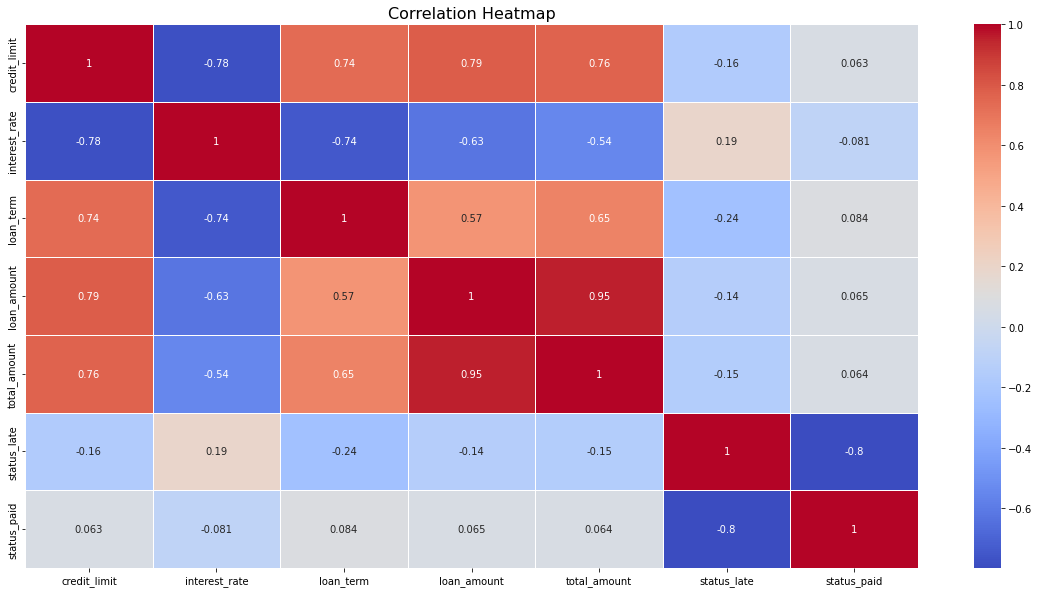

In [40]:
df_status_binary = pd.get_dummies(final_df, columns=['status'])
df_status_binary = df_status_binary[['credit_limit', 'interest_rate', 'loan_term', 'loan_amount', 'total_amount', 'status_late', 'status_paid']]
status_corr = df_status_binary.corr()

# Display a heatmap with correlations
plt.figure(figsize=(20, 10))
sns.heatmap(status_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

From the correlation matrix above, we can notice that:
- Users with a higher credit limit get a lower interest rate, bigger loan terms and total amount.
- When the interest rate is higher, loan terms and the total amount are smaller.
- There is a weak correlation between the status and the loan terms.

We have previously found out that 15% of the loans are late. It looks like this number is not related to the loan terms since they are not correlated with users who paid or did not pay their loans.


### Growth and profitability of lending operations

Let's analyze if the lending operations are growing or not.

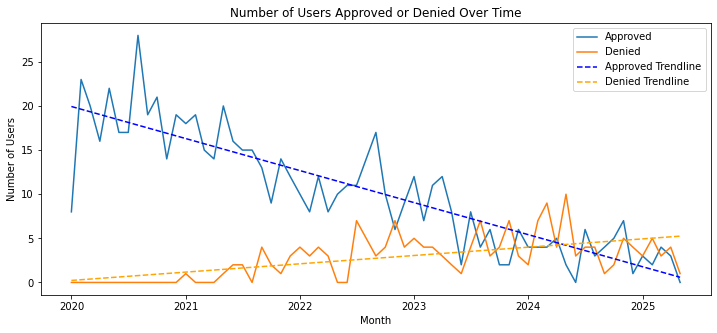

In [43]:
# Plotting a line chart with a line for approved and another for denied loans
plt.figure(figsize=(12, 5))
sns.lineplot(data=counts, x='month', y='approved_count', label='Approved')
sns.lineplot(data=counts, x='month', y='denied_count', label='Denied')

# Adding trendlines
z_approved = np.polyfit(counts['month'].astype(int), counts['approved_count'], 1)
p_approved = np.poly1d(z_approved)
plt.plot(counts['month'], p_approved(counts['month'].astype(int)), linestyle='--', color='blue', label='Approved Trendline')

z_denied = np.polyfit(counts['month'].astype(int), counts['denied_count'], 1)
p_denied = np.poly1d(z_denied)
plt.plot(counts['month'], p_denied(counts['month'].astype(int)), linestyle='--', color='orange', label='Denied Trendline')

plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.title('Number of Users Approved or Denied Over Time')
plt.legend()
plt.show()

The chart above shows that the number of approved loans is decreasing and the number of denied loans is increasing. We can conclude that the operations are diminishing and the business is almost closing.

Let's now analyze the profitability. First, we need to calculate how much the company receives for each loan. We can obtain that number subtracting the loan_amount from the total_amount.

In [45]:
# Merge the users and the loans dataframes
user_loans_df = pd.merge(users_df, loans_df, on='user_id')
user_loans_df['profit'] = user_loans_df['total_amount'] - user_loans_df['loan_amount']

paid_loans_df = user_loans_df[user_loans_df['status'] == 'paid']
paid_loans_df['profit'].mean()

4926.641277719113

On average, the company profit on each paid loan is $4,926.64.



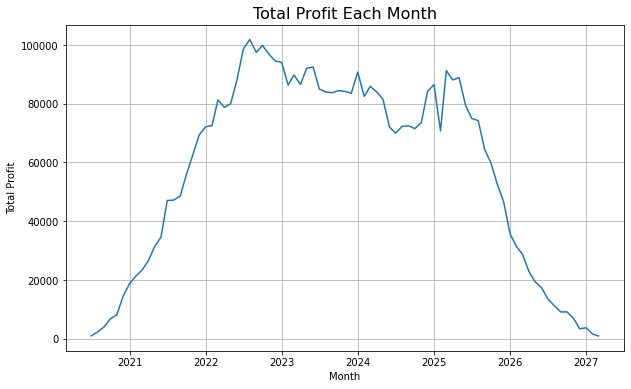

In [46]:
# Create a timeline of payments

# Function to generate installment dates
def generate_installment_dates(row):
    issue_date = pd.to_datetime(row['issue_date'])
    loan_term = int(row['loan_term'])
    installment_dates = [issue_date + timedelta(days=30*i) for i in range(loan_term)]
    return installment_dates

# Create a new dataframe for installments
installments = []

for _, row in paid_loans_df.iterrows():
    installment_dates = generate_installment_dates(row)
    for i, date in enumerate(installment_dates):
        installments.append({
            'loan_id': row['loan_id'],
            'user_id': row['user_id'],
            'installment_number': i + 1,
            'installment_date': date,
            'installment_amount': row['installment_amount'],
            'installment_principal': row['loan_amount'] / row['loan_term']
        })

installments_df = pd.DataFrame(installments)

# Calculate the profit for each installment
installments_df['profit'] = installments_df['installment_amount'] - installments_df['installment_principal']

# Calculate the monthly profit
# Group by month and year, then sum the profit
installments_df['month_year'] = installments_df['installment_date'].dt.to_period('M')
monthly_profit_df = installments_df.groupby('month_year')['profit'].sum().reset_index()

# Convert month_year back to datetime for plotting
monthly_profit_df['month_year'] = monthly_profit_df['month_year'].dt.to_timestamp()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_profit_df['month_year'], monthly_profit_df['profit'])
plt.title('Total Profit Each Month', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Total Profit', fontsize=10)
plt.grid(True)
plt.show()

From this chart, we can notice that now, in 2024, the profit is high. However, since no new loans are being approved, the profit will plummet in 2025 and onwards.

### Disbushment, loan performance, and revenue trends over time

Let's compare the revenues and disbushments over time.

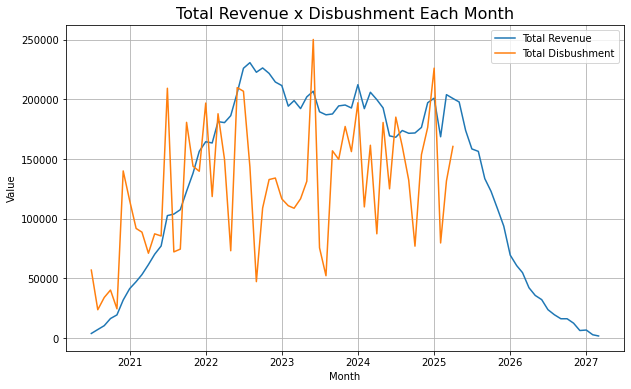

In [48]:
# Calculate the monthly revenue
# Group by month and year, then sum the revenue
monthly_revenue_df = installments_df.groupby('month_year')['installment_amount'].sum().reset_index()

# Convert month_year back to datetime for plotting
monthly_revenue_df['month_year'] = monthly_revenue_df['month_year'].dt.to_timestamp()


# Group by month and year, then sum the loan amount
user_loans_df['issue_date'] = pd.to_datetime(user_loans_df['issue_date'])
user_loans_df['issue_month_year'] = user_loans_df['issue_date'].dt.to_period('M')
monthly_disbushment = user_loans_df.groupby('issue_month_year')['loan_amount'].sum().reset_index()
monthly_disbushment['issue_month_year'] = monthly_disbushment['issue_month_year'].dt.to_timestamp()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_df['month_year'], monthly_revenue_df['installment_amount'], label='Total Revenue')
plt.plot(monthly_disbushment['issue_month_year'], monthly_disbushment['loan_amount'], label='Total Disbushment')
plt.title('Total Revenue x Disbushment Each Month', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.grid(True)
plt.legend()
plt.show()

The chart above shows that in the beginning the disbushment was greater. Then, as loans started to be paid, the profit exceeded the disbushments. Finally, since new loans stopped being approved, the disbushments ceased and the profit started to decrease.

## Dashboard

These are the main charts that can be included in the dashboard:

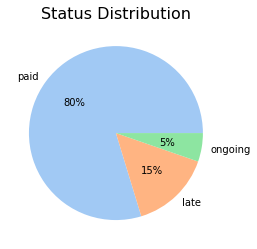

In [13]:
# Count occurrences of each status
status_counts = loans_df['status'].value_counts()
colors = sns.color_palette('pastel')[0:len(status_counts)]

# Create pie chart
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%.0f%%')
plt.title('Status Distribution', fontsize=16)
plt.show()

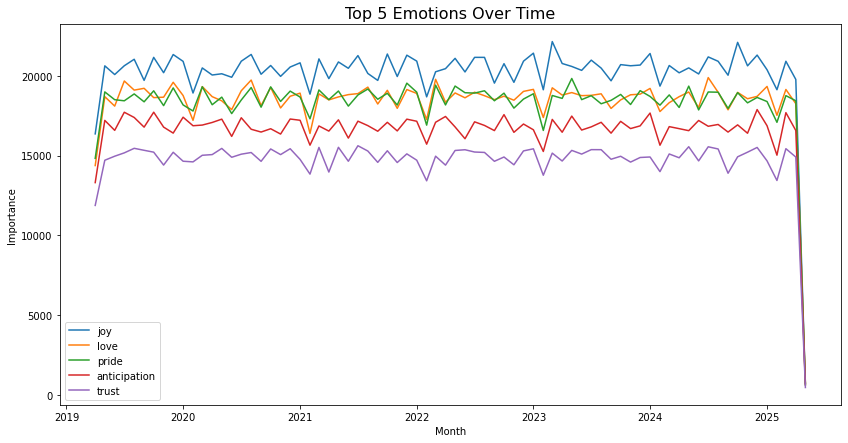

In [16]:
plt.figure(figsize=(14, 7))

# Plot only the top 5 emotions
for emotion in top_5_emotions:
    plt.plot(pivot_df.index, pivot_df[emotion], label=emotion)

plt.xlabel('Month', fontsize = 10)
plt.ylabel('Importance', fontsize = 10)
plt.title('Top 5 Emotions Over Time', fontsize = 16)
plt.legend()
plt.show()

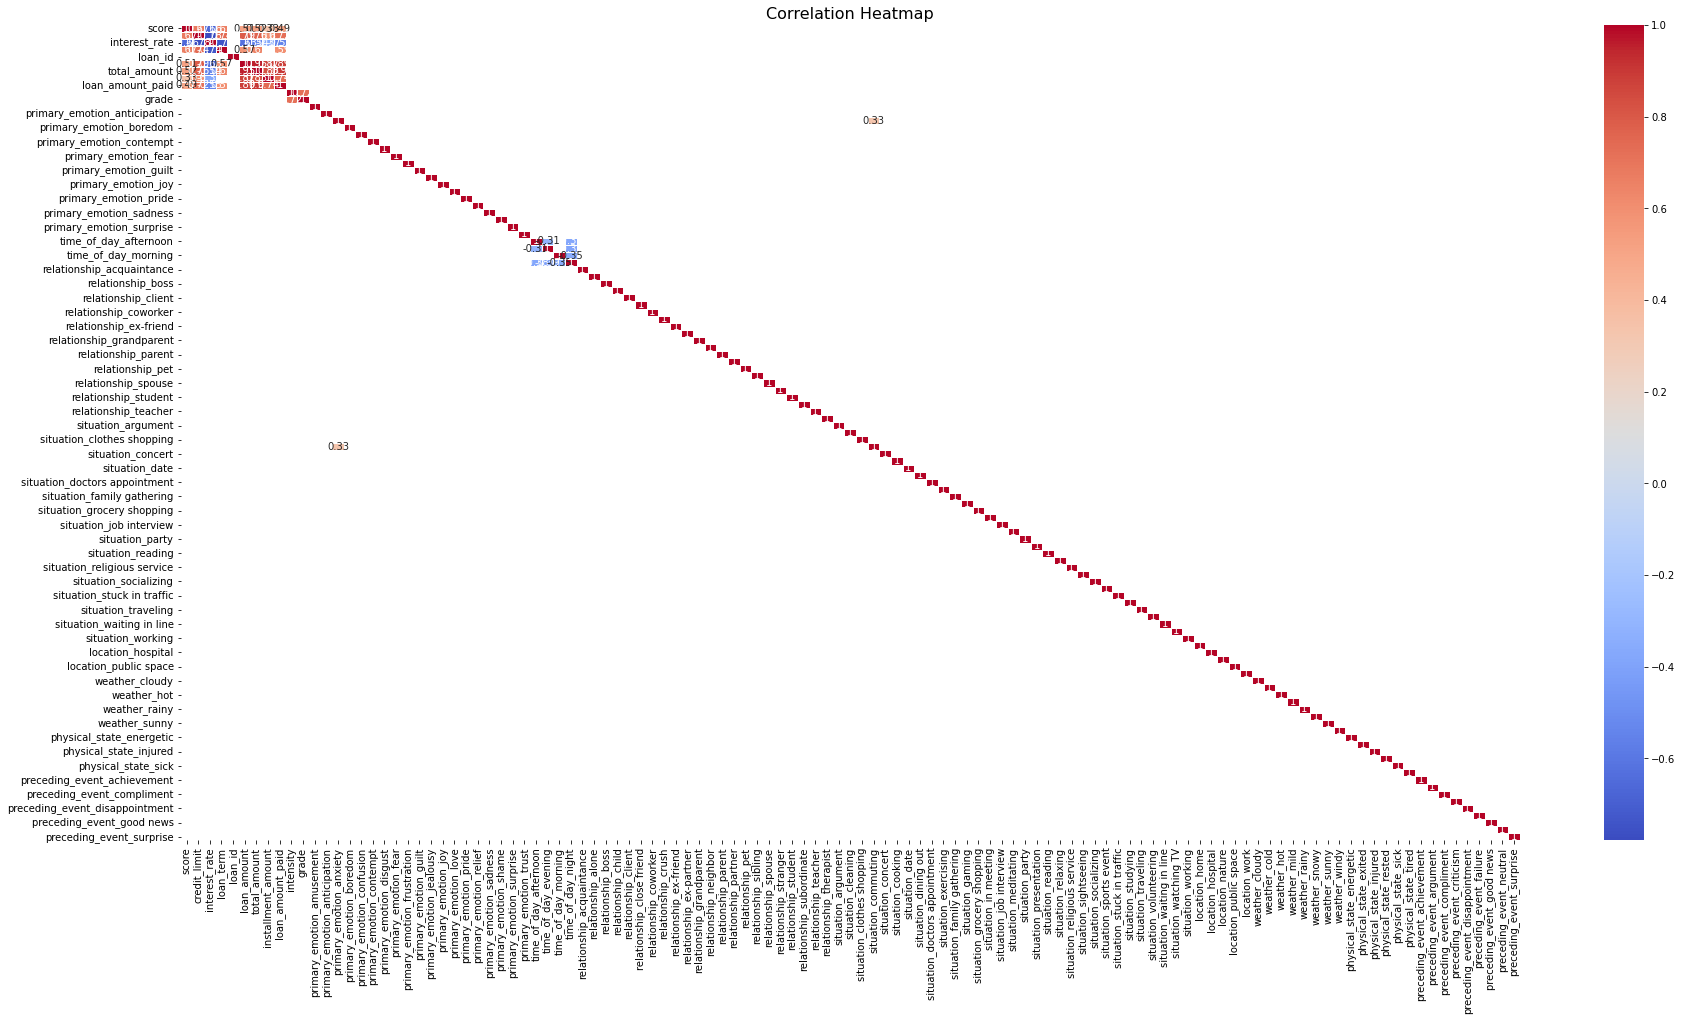

In [39]:
# Display a heatmap with correlations
plt.figure(figsize=(30, 15))
sns.heatmap(corr_matrix_binary, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

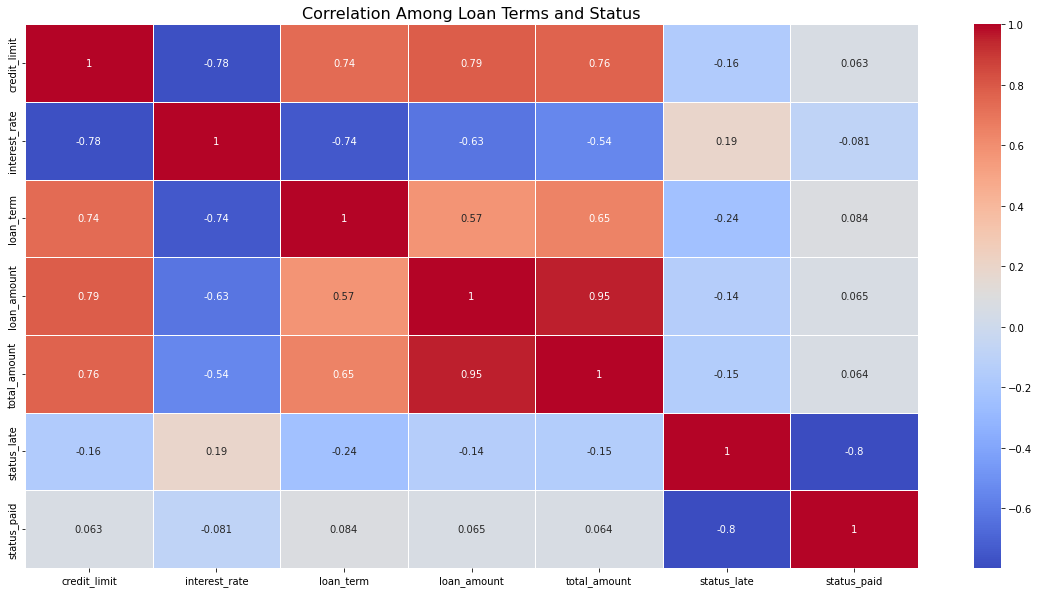

In [42]:
# Display a heatmap with correlations
plt.figure(figsize=(20, 10))
sns.heatmap(status_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Among Loan Terms and Status', fontsize=16)
plt.show()

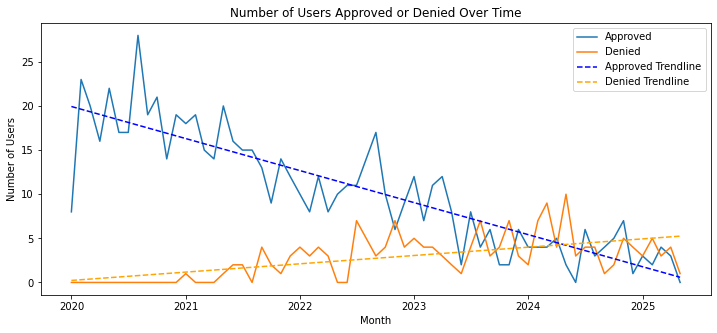

In [44]:
# Plotting a line chart with a line for approved and another for denied loans
plt.figure(figsize=(12, 5))
sns.lineplot(data=counts, x='month', y='approved_count', label='Approved')
sns.lineplot(data=counts, x='month', y='denied_count', label='Denied')

# Adding trendlines
z_approved = np.polyfit(counts['month'].astype(int), counts['approved_count'], 1)
p_approved = np.poly1d(z_approved)
plt.plot(counts['month'], p_approved(counts['month'].astype(int)), linestyle='--', color='blue', label='Approved Trendline')

z_denied = np.polyfit(counts['month'].astype(int), counts['denied_count'], 1)
p_denied = np.poly1d(z_denied)
plt.plot(counts['month'], p_denied(counts['month'].astype(int)), linestyle='--', color='orange', label='Denied Trendline')

plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.title('Number of Users Approved or Denied Over Time')
plt.legend()
plt.show()

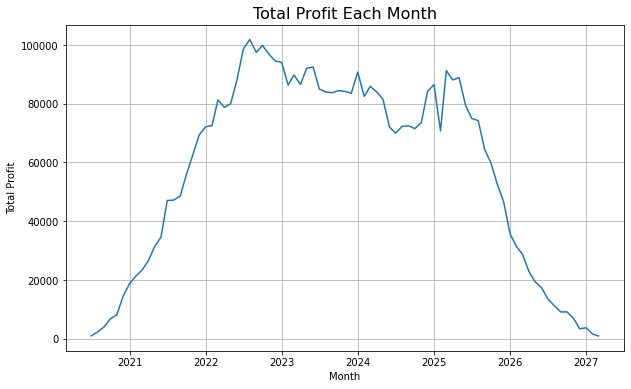

In [47]:
# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_profit_df['month_year'], monthly_profit_df['profit'])
plt.title('Total Profit Each Month', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Total Profit', fontsize=10)
plt.grid(True)
plt.show()

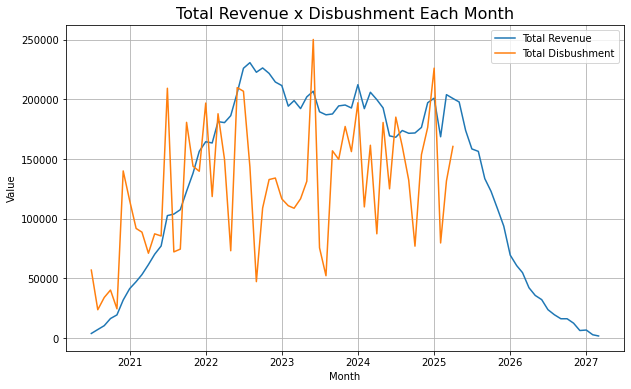

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_df['month_year'], monthly_revenue_df['installment_amount'], label='Total Revenue')
plt.plot(monthly_disbushment['issue_month_year'], monthly_disbushment['loan_amount'], label='Total Disbushment')
plt.title('Total Revenue x Disbushment Each Month', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.grid(True)
plt.legend()
plt.show()